In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # n-gram
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [141]:
file_path = './../../Fed1_dataset/Interest_rate_prediction.csv'

# FED_ir의 의미 : FED interest rate
df_irp = pd.read_csv(file_path)

df_irp.head()

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_text,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM
0,2008-12-01,0.25,0.0,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,2.50,Prepared at the Federal Reserve Bank of Minnea...,0.080,0.839,0.082,0.9133,2008-12
1,2009-01-01,0.25,0.0,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-01
2,2009-02-01,0.25,0.0,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-02
3,2009-03-01,0.25,0.0,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,1.50,Prepared at the Federal Reserve Bank of San Fr...,0.083,0.839,0.078,0.5459,2009-03
4,2009-04-01,0.25,0.0,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,1.25,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-04


1단계 : 정형 데이터 EDA

In [143]:
df_irp['DATE'] = pd.to_datetime(df_irp['DATE'])

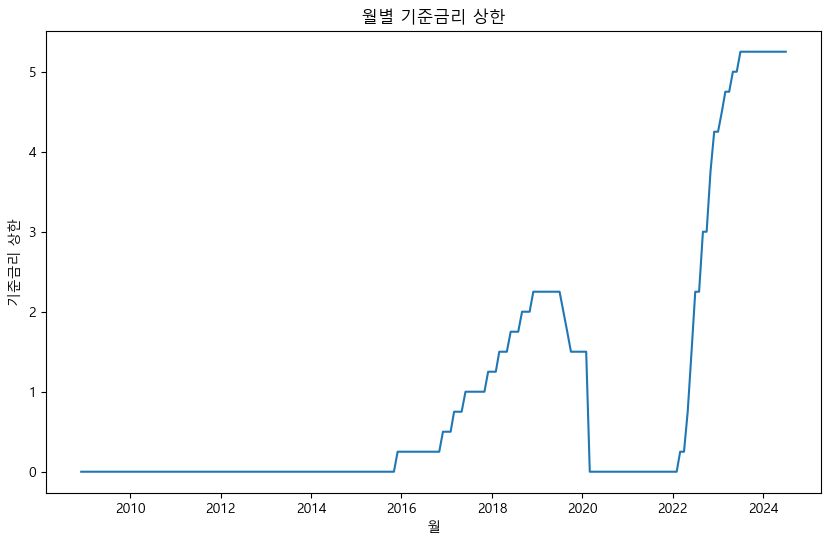

In [145]:
plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['DFEDTARL'])
plt.title('월별 기준금리 상한')
plt.xlabel('월')
plt.ylabel('기준금리 상한')
plt.show()

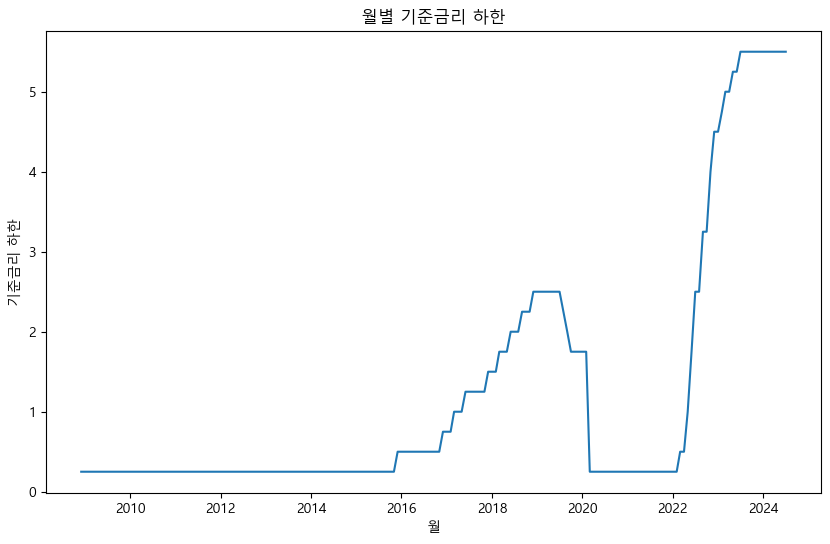

In [147]:
plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['DFEDTARU'])
plt.title('월별 기준금리 하한')
plt.xlabel('월')
plt.ylabel('기준금리 하한')
plt.show()

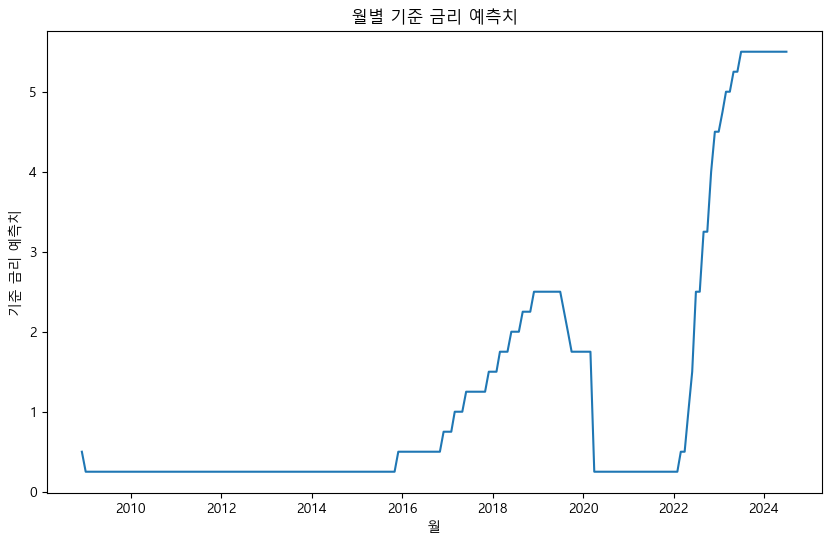

In [149]:
plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['IR_FORCAST'])
plt.title('월별 기준 금리 예측치')
plt.xlabel('월')
plt.ylabel('기준 금리 예측치')
plt.show()

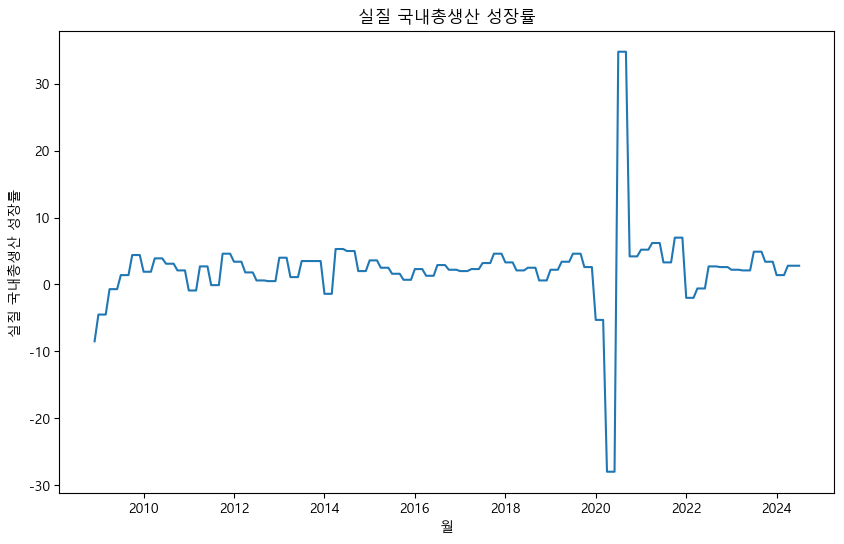

In [151]:
plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['GDPGR'])
plt.title('실질 국내총생산 성장률')
plt.xlabel('월')
plt.ylabel('실질 국내총생산 성장률')
plt.show()

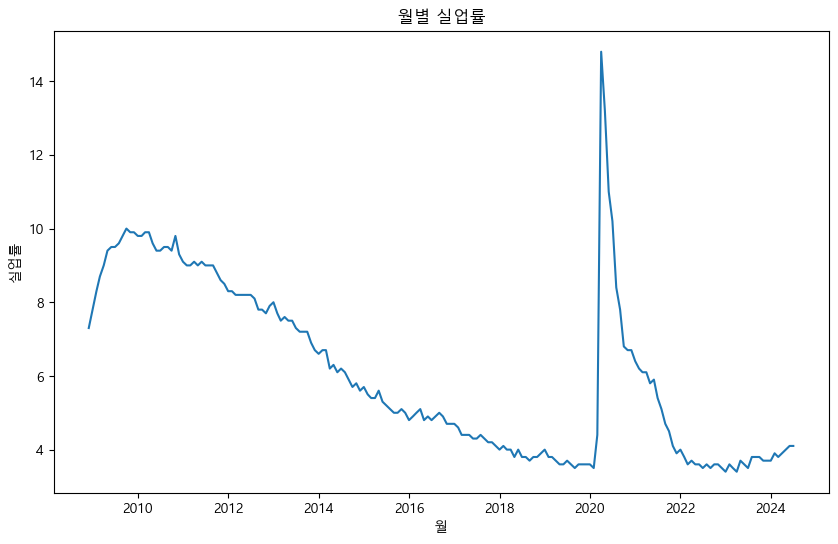

In [153]:
plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['UNRATE'])
plt.title('월별 실업률')
plt.xlabel('월')
plt.ylabel('실업률')
plt.show()

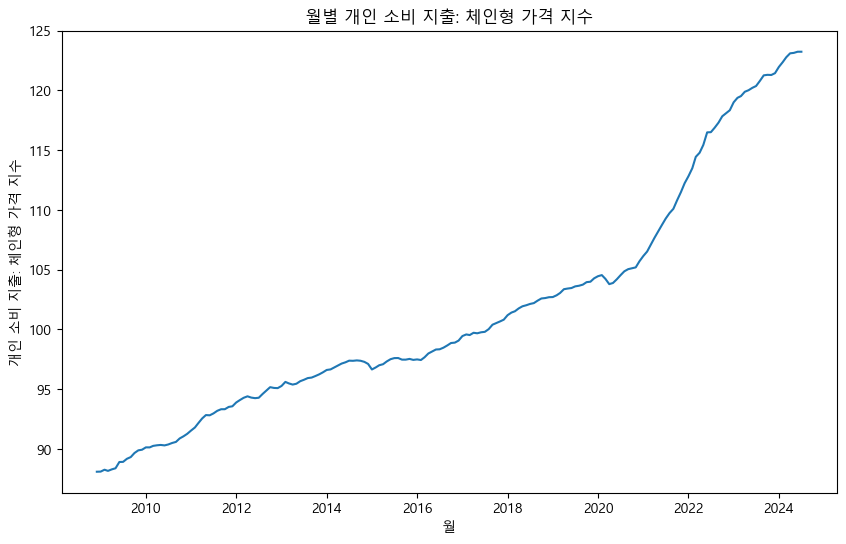

In [155]:
plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['PCEPI'])
plt.title('월별 개인 소비 지출: 체인형 가격 지수')
plt.xlabel('월')
plt.ylabel('개인 소비 지출: 체인형 가격 지수')
plt.show()

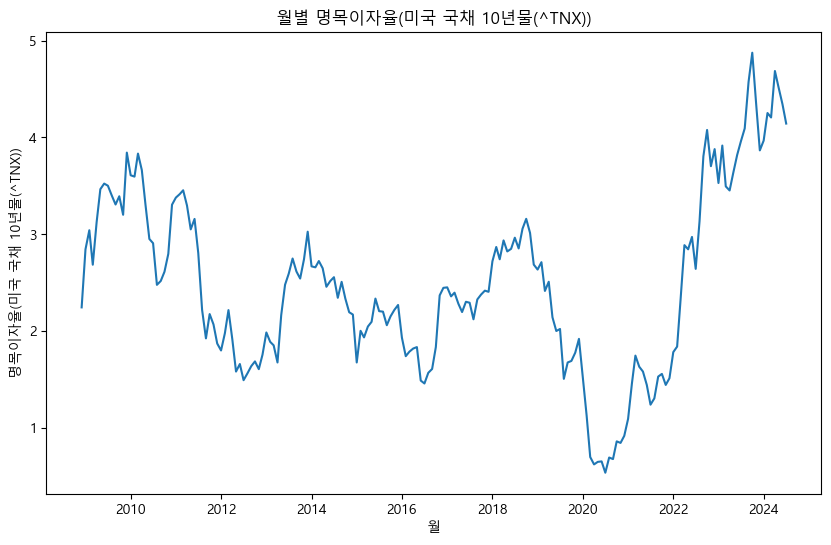

In [157]:
plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['TNX'])
plt.title('월별 명목이자율(미국 국채 10년물(^TNX))')
plt.xlabel('월')
plt.ylabel('명목이자율(미국 국채 10년물(^TNX))')
plt.show()

환율 데이터의 경우 그래프가 이상하게 나와서 아래와 같은 절차로 데이터 확인
1. 시작일~2010-01-01 기간동안으로 그래프 그리기=>환율이 낮은 것이 상단에 위치
2. datatype 확인 결과 환율이 다른 컬럼과 달리 object type으로 되어 있음=>
3. float64로 변경 시도(df_irp['USD'] = pd.to_numeric(df_irp['USD']))했으나 오류 발생하여 크롤링 프로그램 재점검 

C:\Users\dybae\AppData\Local\Temp\ipykernel_21672\2582805857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_irp_filter['DATE'] = pd.to_datetime(df_irp_filter['DATE'])


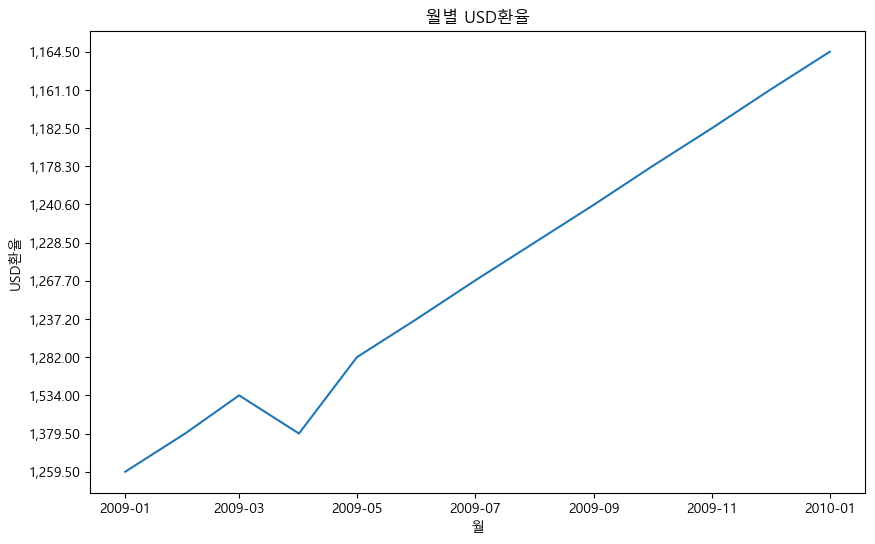

In [95]:
df_irp_filter = df_irp[df_irp['DATE']<='2010-01-01']
df_irp_filter['DATE'] = pd.to_datetime(df_irp_filter['DATE'])

plt.figure(figsize=(10,6))
plt.plot(df_irp_filter['DATE'], df_irp_filter['USD'])
plt.title('월별 USD환율')
plt.xlabel('월')
plt.ylabel('USD환율')
plt.show()

In [67]:
specific_columns = ['DATE', 'USD']
df_irp.head(20)[specific_columns]

,DATE,USD
0,2009-01-01,"1,259.50"
1,2009-02-01,"1,379.50"
2,2009-03-01,"1,534.00"
3,2009-04-01,"1,379.50"
4,2009-05-01,"1,282.00"
5,2009-06-01,"1,237.20"
6,2009-07-01,"1,267.70"
7,2009-08-01,"1,228.50"
8,2009-09-01,"1,240.60"
9,2009-10-01,"1,178.30"


In [71]:
df_irp.dtypes

DATE               datetime64[ns]
index                       int64
DFEDTARU                  float64
DFEDTARL                  float64
IR_FORCAST                float64
A191RL1Q225SBEA           float64
UNRATE                    float64
PCEPI                     float64
TNX                       float64
USD                        object
KR_IR                     float64
ECB_IR                    float64
BB_text                    object
BB_neg                    float64
BB_neu                    float64
BB_pos                    float64
BB_sentiment              float64
DATE_YM                    object
dtype: object

In [73]:
df_irp['USD'] = pd.to_numeric(df_irp['USD'])

ValueError: Unable to parse string "1,259.50" at position 0

여기서부터 정상 출력

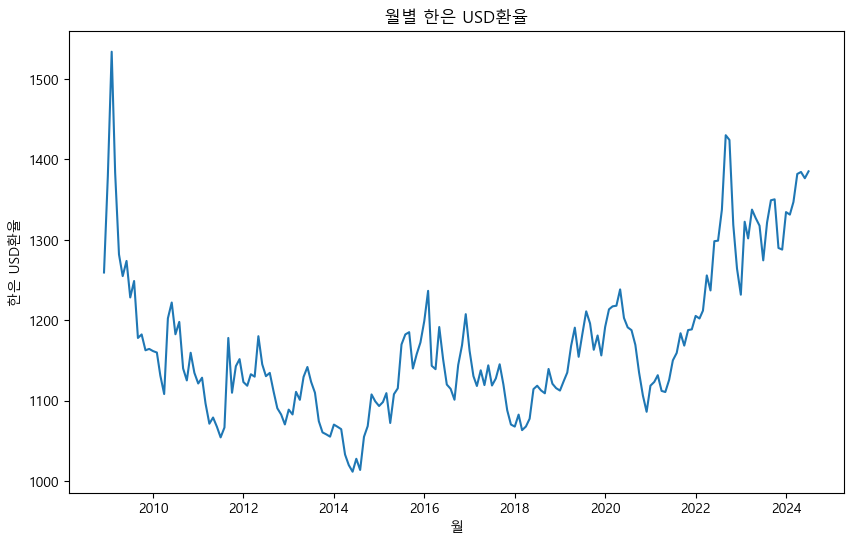

In [159]:
df_irp['DATE'] = pd.to_datetime(df_irp['DATE'])

plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['USD'])
plt.title('월별 한은 USD환율')
plt.xlabel('월')
plt.ylabel('한은 USD환율')
plt.show()

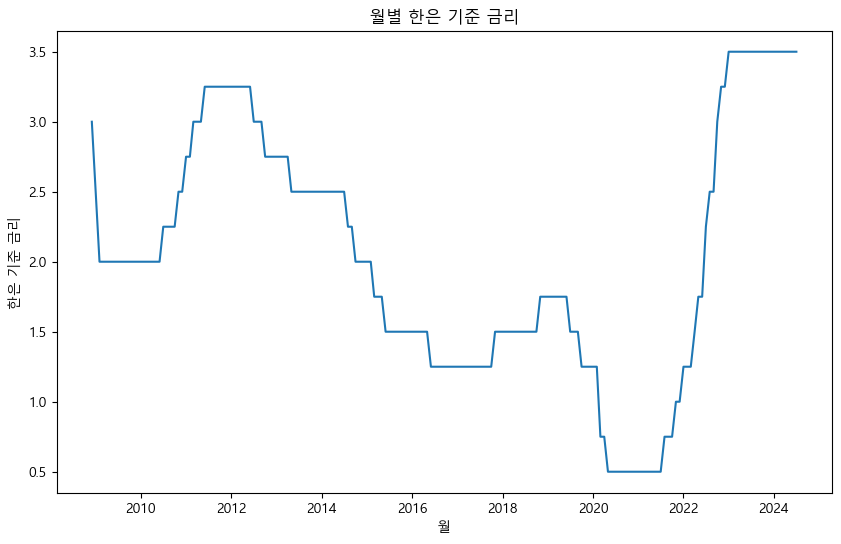

In [161]:
plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['KR_IR'])
plt.title('월별 한은 기준 금리')
plt.xlabel('월')
plt.ylabel('한은 기준 금리')
plt.show()

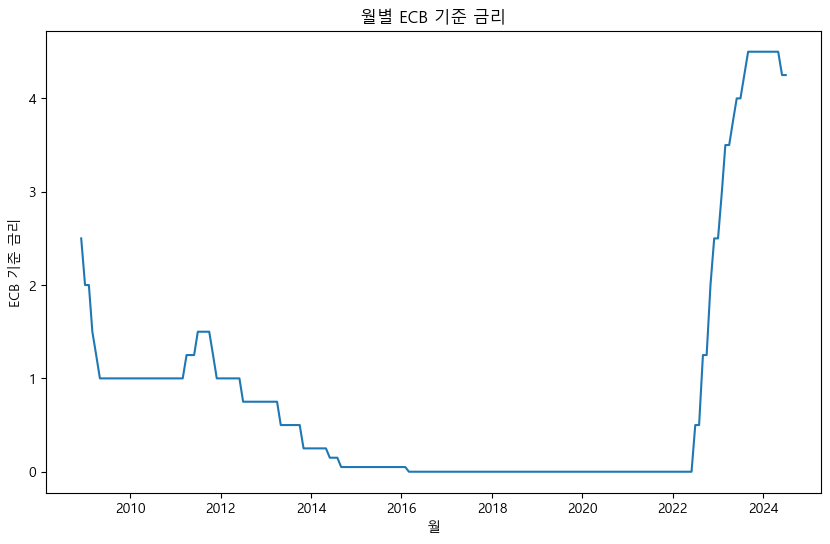

In [163]:
df_irp['DATE'] = pd.to_datetime(df_irp['DATE'])

plt.figure(figsize=(10,6))
plt.plot(df_irp['DATE'], df_irp['ECB_IR'])
plt.title('월별 ECB 기준 금리')
plt.xlabel('월')
plt.ylabel('ECB 기준 금리')
plt.show()

In [165]:
dic_irp = {
    'DATE': '일자',
    'DFEDTARU': '연준 기준 금리 상한',
    'DFEDTARL': '연준 기준 금리 하한',
    'IR_FORCAST': '연준 기준 금리 예측치',
    'GDPGR': '실질 국내총생산 성장률',
    'UNRATE': '실업률',
    'PCEPI': '개인 소비 지출: 체인형 가격 지수',
    'TNX': '명목이자율',
    'USD': '한은 USD환율',
    'KR_IR': '한은 기준 금리',
    'ECB_IR': 'ECB 기준 금리',
    'BB_neg': 'Beige book 부정',
    'BB_neu': 'Beige book 중립',
    'BB_pos': 'Beige book 긍정',
    'BB_sentiment': 'Beige book 감정'
}
keys = list(dic_irp.keys())

# 상관관계 계산
for column1 in keys:
    if column1 in ('DATE', 'DFEDTARL'):
        continue
    for column2 in keys:
        if column2 in ('DATE', 'DFEDTARL', column1):
            continue
        # 상관관계 계산
        correlation = df_irp[column1].corr(df_irp[column2])
        print(f'correlation {column1}/{column2}: {correlation}')

correlation DFEDTARU/IR_FORCAST: 0.9975598386883944
correlation DFEDTARU/GDPGR: 0.029379102962898026
correlation DFEDTARU/UNRATE: -0.5822525551329388
correlation DFEDTARU/PCEPI: 0.8018107356098094
correlation DFEDTARU/TNX: 0.6268462909001203
correlation DFEDTARU/USD: 0.6144362172770361
correlation DFEDTARU/KR_IR: 0.4550514138692885
correlation DFEDTARU/ECB_IR: 0.7547350032255785
correlation DFEDTARU/BB_neg: 0.20104080809250816
correlation DFEDTARU/BB_neu: -0.300769710127912
correlation DFEDTARU/BB_pos: 0.15095299070422388
correlation DFEDTARU/BB_sentiment: 0.11207153936037625
correlation IR_FORCAST/DFEDTARU: 0.9975598386883943
correlation IR_FORCAST/GDPGR: 0.02212925967670242
correlation IR_FORCAST/UNRATE: -0.5852493340809778
correlation IR_FORCAST/PCEPI: 0.8018096221197861
correlation IR_FORCAST/TNX: 0.6172018177582136
correlation IR_FORCAST/USD: 0.6174824716857112
correlation IR_FORCAST/KR_IR: 0.4496254612163794
correlation IR_FORCAST/ECB_IR: 0.7541907382423486
correlation IR_FORCAST

2. 비정형 데이터 EDA

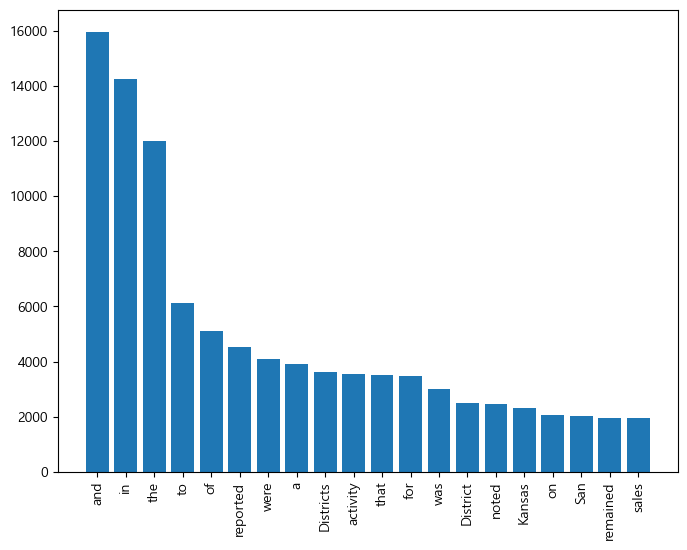

In [167]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

In [169]:
df_irp['BB_text'] = df_irp['BB_text'].str.lower()  # 소문자로
df_irp['BB_text'] = df_irp['BB_text'].str.strip()  # 앞뒤 공백 제거
df_irp['BB_text'] = df_irp['BB_text'].str.replace('\s+', ' ', regex=True)  # 중간 공백 제거
# 숫자, 대문자, 소문자 알파벳 및 공백을 제외한 모든 문자 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [171]:
# 불용어 제거
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_irp['BB_text'] = df_irp['BB_text'].apply(remove_stopwords)

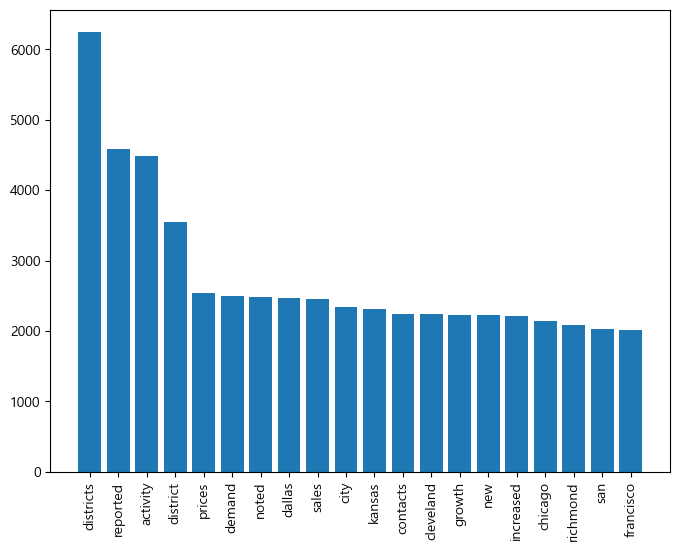

In [173]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

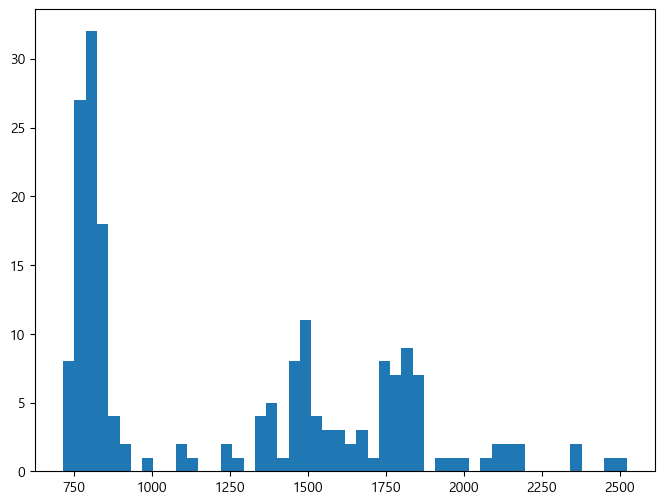

In [175]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

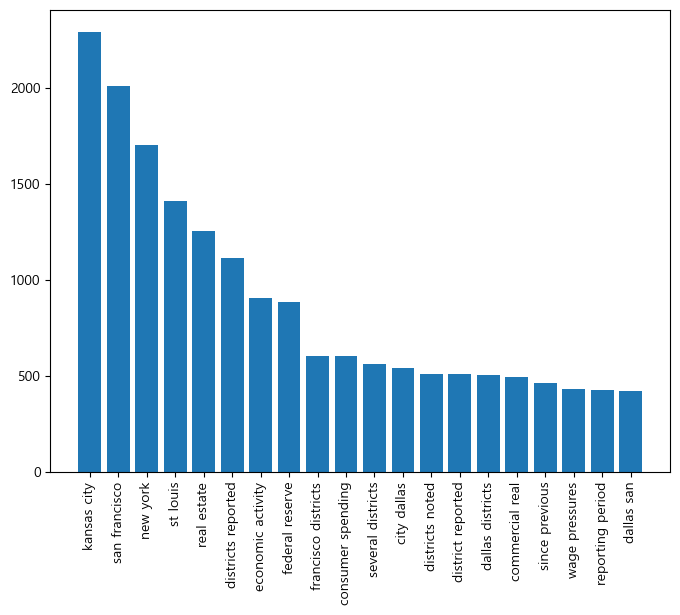

In [177]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

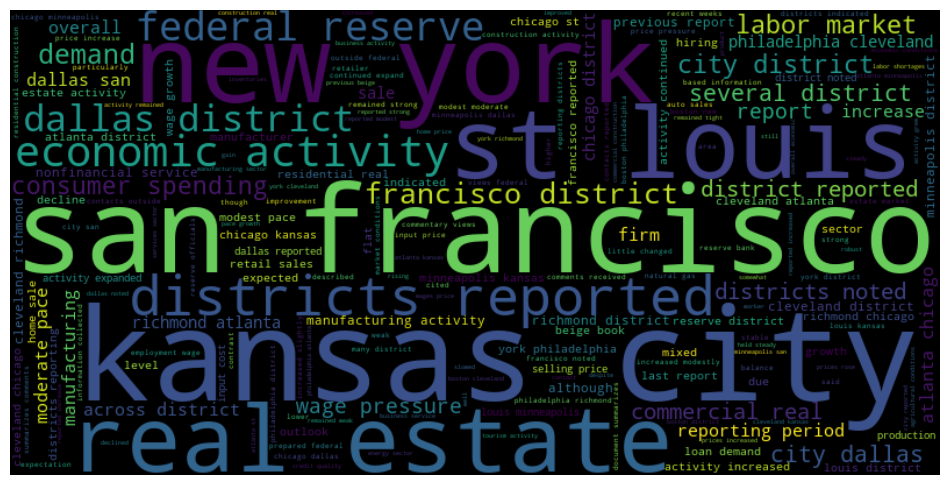

In [179]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [180]:
# 연방준비은행 지역 목록 제거st louis와 같은 경우도 감안
federal_reserve_banks = [
    "boston", 
    "new york", 
    "philadelphia", 
    "cleveland", 
    "richmond", 
    "atlanta", 
    "chicago", 
    "st. louis", 
    "minneapolis", 
    "kansas city", 
    "dallas", 
    "san francisco",
    "st",
    "louis"
]

# 연방준비은행 지역 필터링 함수
def remove_federal_reserve_banks(text, bank_list):
    # 소문자 변환 및 정규표현식을 사용하여 지역 이름 제거
    for bank in bank_list:
        bank_pattern = re.compile(re.escape(bank), re.IGNORECASE)
        text = bank_pattern.sub('', text)
    return text

# 연방준비은행 지역 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: remove_federal_reserve_banks(x, federal_reserve_banks))

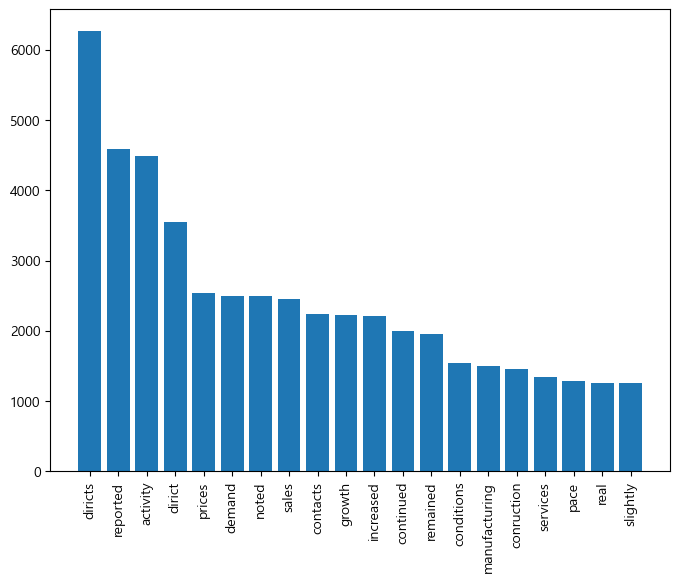

In [183]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

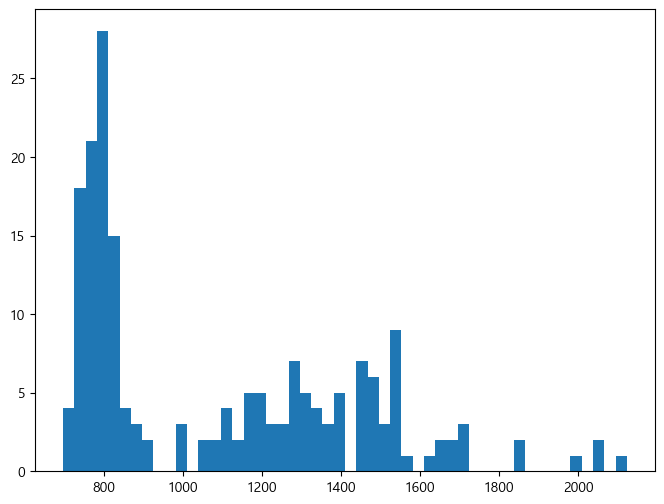

In [185]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

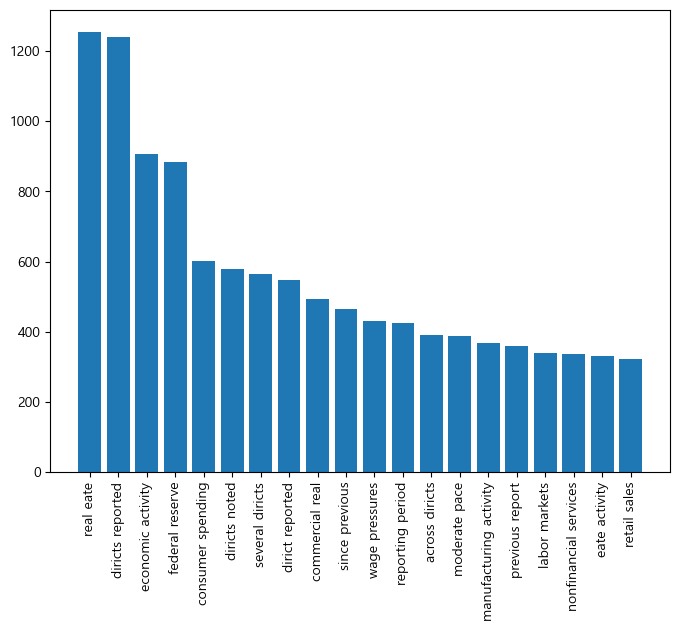

In [187]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

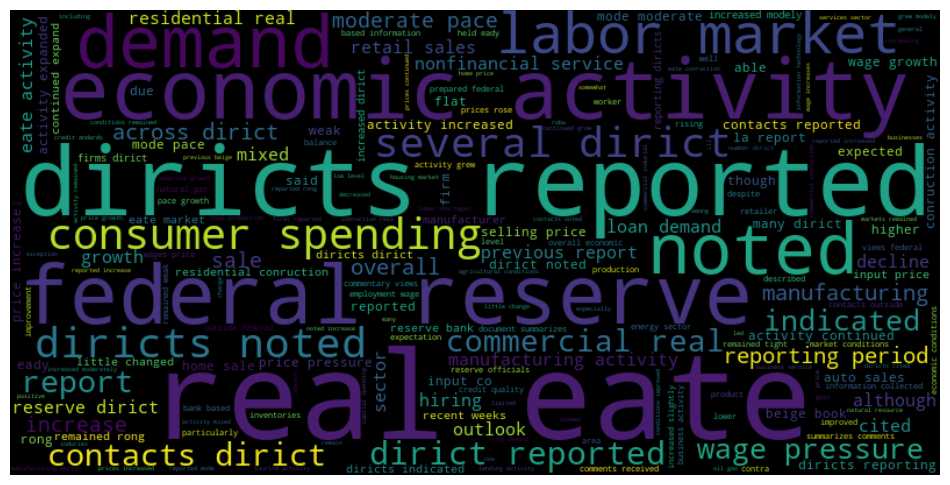

In [189]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

감정분석 : 전처리 이전과 이후 비교

In [191]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dybae\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [193]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']

df_irp[['f_neg', 'f_neu', 'f_pos', 'f_sentiment']] = df_irp['BB_text'].apply(lambda text: pd.Series(get_vader_sentiment(text)))

df_irp

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,...,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM,text_length,f_neg,f_neu,f_pos,f_sentiment
0,2008-12-01,0.25,0.00,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,...,0.080,0.839,0.082,0.9133,2008-12,916,0.111,0.804,0.085,-0.9594
1,2009-01-01,0.25,0.00,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,...,0.061,0.865,0.074,0.9952,2009-01,1451,0.109,0.787,0.103,-0.6317
2,2009-02-01,0.25,0.00,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,...,0.061,0.865,0.074,0.9952,2009-02,1451,0.109,0.787,0.103,-0.6317
3,2009-03-01,0.25,0.00,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,...,0.083,0.839,0.078,0.5459,2009-03,1376,0.116,0.786,0.098,-0.8791
4,2009-04-01,0.25,0.00,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,...,0.092,0.826,0.082,-0.6999,2009-04,1295,0.124,0.779,0.097,-0.9705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2024-03-01,5.50,5.25,5.50,1.4,3.8,122.782,4.206,1347.2,3.5,...,0.056,0.797,0.147,0.9991,2024-03,824,0.067,0.793,0.141,0.9966
184,2024-04-01,5.50,5.25,5.50,2.8,3.9,123.109,4.686,1382.0,3.5,...,0.068,0.807,0.126,0.9974,2024-04,790,0.071,0.813,0.117,0.9886
185,2024-05-01,5.50,5.25,5.50,2.8,4.0,123.146,4.514,1384.5,3.5,...,0.076,0.783,0.141,0.9982,2024-05,817,0.072,0.794,0.135,0.9953
186,2024-06-01,5.50,5.25,5.50,2.8,4.1,123.243,4.343,1376.7,3.5,...,0.076,0.783,0.141,0.9982,2024-06,817,0.072,0.794,0.135,0.9953


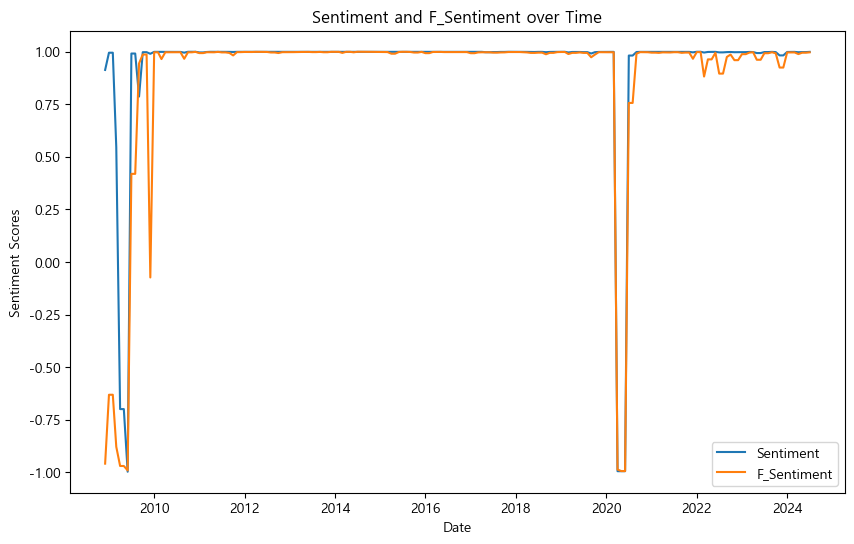

In [195]:
# 감정 합쳐서 보여주기

# 플롯 생성
plt.figure(figsize=(10, 6))
plt.plot(df_irp['DATE'], df_irp['BB_sentiment'], label='Sentiment')
plt.plot(df_irp['DATE'], df_irp['f_sentiment'], label='F_Sentiment')

# 제목과 레이블 설정
plt.title('Sentiment and F_Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Scores')
plt.legend()
# 플롯 보여주기
plt.show()

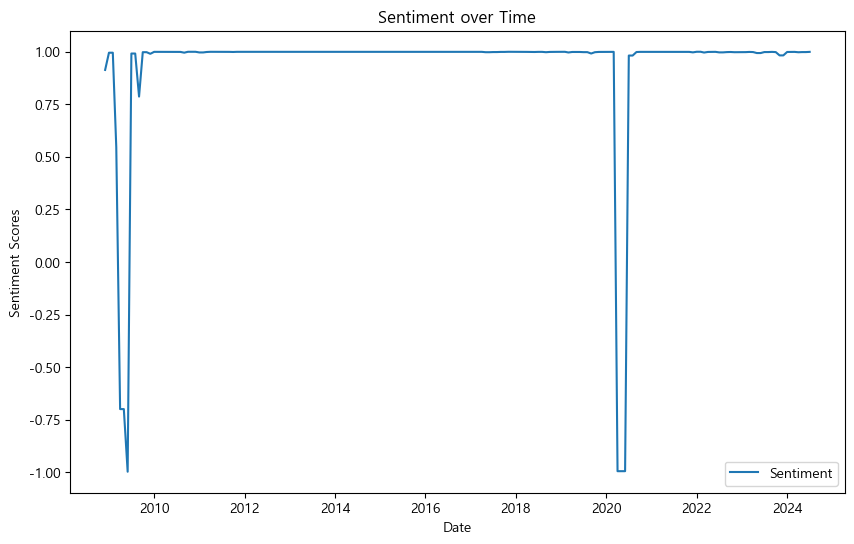

In [197]:
# fiter 안된 감점
plt.figure(figsize=(10, 6))
plt.plot(df_irp['DATE'], df_irp['BB_sentiment'], label='Sentiment')

# 제목과 레이블 설정
plt.title('Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Scores')
plt.legend()
# 플롯 보여주기
plt.show()

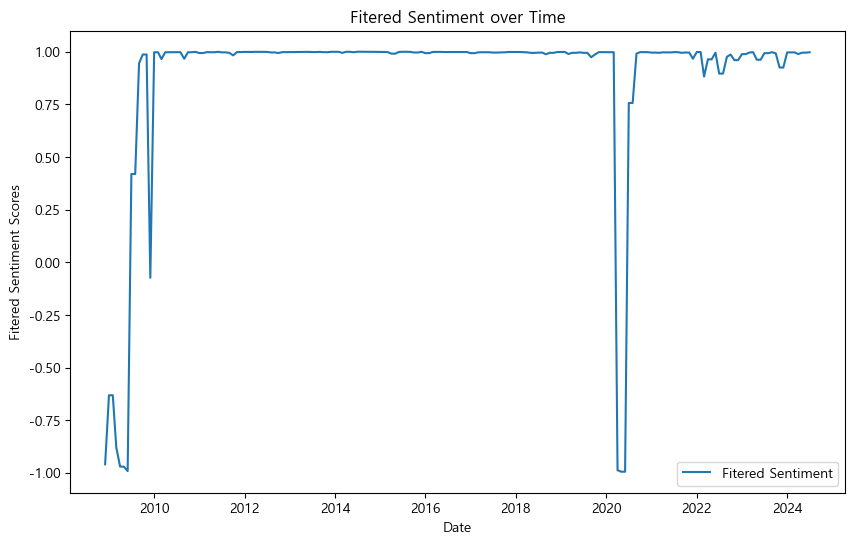

In [199]:
# fiter 된 감점
plt.figure(figsize=(10, 6))
plt.plot(df_irp['DATE'], df_irp['f_sentiment'], label='Fitered Sentiment')

# 제목과 레이블 설정
plt.title('Fitered Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Fitered Sentiment Scores')
plt.legend()
# 플롯 보여주기
plt.show()